Checking residues in chain X...
Residue: 1 - PRO
Residue: 2 - GLN
Residue: 3 - LYS
Residue: 4 - SER
Residue: 5 - LYS
Residue: 6 - VAL
Residue: 7 - ASP
Residue: 8 - CYX
Residue: 9 - ASN
Residue: 10 - LYS
Residue: 11 - GLY
Residue: 12 - VAL
Residue: 13 - THR
Residue: 14 - GLY
Residue: 15 - THR
Residue: 16 - VAL
Residue: 17 - TYR
Residue: 18 - GLU
Residue: 19 - TYR
Residue: 20 - GLY
Residue: 21 - ALA
Residue: 22 - ASN
Residue: 23 - THR
Residue: 24 - ILE
Residue: 25 - ASP
Residue: 26 - GLY
Residue: 27 - GLY
Residue: 28 - GLU
Residue: 29 - PHE
Residue: 30 - VAL
Residue: 31 - ASN
Residue: 32 - PHE
Residue: 33 - GLN
Residue: 34 - GLN
Residue: 35 - TYR
Residue: 36 - ALA
Residue: 37 - GLY
Residue: 38 - LYS
Residue: 39 - HID
Residue: 40 - ILE
Residue: 41 - LEU
Residue: 42 - PHE
Residue: 43 - VAL
Residue: 44 - ASN
Residue: 45 - VAL
Residue: 46 - ALA
Residue: 47 - SER
Residue: 48 - PHE
Residue: 49 - CYS
Residue: 50 - GLY
Residue: 51 - LEU
Residue: 52 - THR
Residue: 53 - ALA
Residue: 54 - THR
Resid

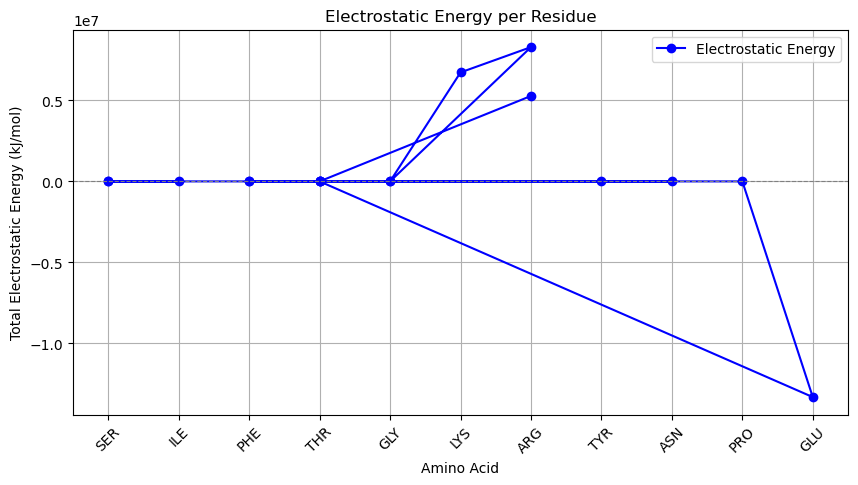

In [8]:
import numpy as np
from Bio import PDB

# Define amino acid charges at physiological pH
amino_acid_charges = {
    'ASP': -1, 'GLU': -1, 'ARG': 1, 'LYS': 1, 'HIS': 0.1,
    'CYS': 0, 'TYR': 0, 'ASN': 0, 'GLN': 0, 'SER': 0, 'THR': 0,
    'ALA': 0, 'VAL': 0, 'ILE': 0, 'LEU': 0, 'MET': 0, 'PHE': 0,
    'TRP': 0, 'PRO': 0, 'GLY': 0, 'OTHER': 0
}

# List of residue positions to analyze
residues = [
    4, 24, 47, 48, 52, 54, 60, 74, 87, 99, 102, 104,
    107, 139, 142, 143, 144, 177, 178, 181
]

# Electrostatic energy calculation using Coulomb's Law
def coulomb_energy(q1, q2, r, dielectric=80):
    k = 8.9875e9  # Coulomb constant (N·m²/C²)
    if r == 0:
        return float('inf')  # Avoid division by zero
    return (k * q1 * q2) / (dielectric * r)

# Function to parse PDB and compute electrostatics
def calculate_electrostatics(pdb_file, chain_id='X'):
    parser = PDB.PDBParser(QUIET=True)
    structure = parser.get_structure("protein", pdb_file)
    model = structure[0]  # Use first model (single structure case)

    # Check all residues in chain X and print
    print("Checking residues in chain X...")
    for chain in model:
        if chain.id == chain_id:  # Check only the specified chain
            for res in chain:
                print(f"Residue: {res.id[1]} - {res.resname}")

    # Check for the presence of Cα atoms in the specified residues
    print("\nChecking for Cα atoms in residues...")
    for chain in model:
        if chain.id == chain_id:
            for res in chain:
                atoms = [atom.name for atom in res]
                if 'CA' not in atoms:
                    print(f"Residue {res.id[1]} ({res.resname}) does not have a Cα atom.")
                else:
                    print(f"Residue {res.id[1]} ({res.resname}) has a Cα atom.")

    # Extract Cα coordinates for specified residues
    residue_info = {}
    for chain in model:
        if chain.id == chain_id:
            for res in chain:
                if res.id[1] in residues and res.resname in amino_acid_charges:
                    ca_atom = res['CA'] if 'CA' in res else None
                    if ca_atom:
                        residue_info[res.id[1]] = (res.resname, ca_atom.coord)

    if not residue_info:
        print("Error: No matching residues found in the PDB file.")
        return

    print(f"\nExtracted {len(residue_info)} residues:")
    for res, (name, coord) in residue_info.items():
        print(f"  Residue {res}: {name}, Coord: {coord}")

    # Compute pairwise electrostatic interactions
    energies = {res: 0 for res in residue_info}  # Initialize energy storage
    for i, (res1, (aa1, coord1)) in enumerate(residue_info.items()):
        for res2, (aa2, coord2) in list(residue_info.items())[i+1:]:
            distance = np.linalg.norm(coord1 - coord2)  # Compute Euclidean distance
            q1, q2 = amino_acid_charges.get(aa1, 0), amino_acid_charges.get(aa2, 0)
            energy = coulomb_energy(q1, q2, distance)  # Electrostatic energy

            energies[res1] += energy
            energies[res2] += energy

    if all(e == 0 for e in energies.values()):
        print("Warning: All electrostatic energy values are zero.")

    # Print results
    print(f"\n{'Residue':<8} {'Amino Acid':<12} {'Total Energy (kJ/mol)':<20}")
    print("=" * 40)
    for res, energy in energies.items():
        print(f"{res:<8} {residue_info[res][0]:<12} {energy:<20.3e}")

    # Prepare data for plotting
    amino_acids = [residue_info[res][0] for res in energies]
    energy_values = [energies[res] for res in energies]

    # Debugging print before plotting
    print(f"\nPlotting {len(amino_acids)} amino acids with energies: {energy_values}")

    # Plot results
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 5))
    plt.plot(amino_acids, energy_values, marker='o', linestyle='-', color='b', label="Electrostatic Energy")
    plt.xlabel("Amino Acid")
    plt.ylabel("Total Electrostatic Energy (kJ/mol)")
    plt.title("Electrostatic Energy per Residue")
    plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)  # Zero energy reference line
    plt.grid(True)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.legend()
    plt.show()

# Example usage
pdb_file = "/home/hp/nayanika/github/GPX6/prep_structures/original_mousecys.pdb"  # Replace with your actual PDB file
calculate_electrostatics(pdb_file, chain_id='X')
